In [1]:
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from lib import plotting

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
env.observation_space.sample()

array([-0.6268937 ,  0.84748644, -0.12073544,  0.1159829 , -7.538643  ,
       10.945333  ], dtype=float32)

In [4]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))
# np.amin(observation_examples,axis=0)

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [5]:
class Function_Approximator():
    
    def __init__(self):
        
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
            
    
    def featurize_state(self, state):
        
        scaled = scaler.transform([state])
        features = featurizer.transform(scaled)
        return features[0]
    
    
    def predict(self, s, a=None):
        
        state_features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([state_features])[0] for m in self.models])
        else:
            return self.models[a].predict([state_features])[0]
        
    def update(self, s, a, y):
       
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [6]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def sarsa(env, estimator, num_episodes, alpha=1, discount_factor=0.99, epsilon=0.1, epsilon_decay=1.0):
    
#     alpha = 1
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Initialize 's'
        state = env.reset()
        

            
        for t in itertools.count():
            
            # Choose 'a' from 's' using policy derived from Q
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take action 'a' and observe r, s'
            next_state, reward, end, _ = env.step(action)
            env.render()
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Get Q(s,~)
            q_values_this = estimator.predict(state)
            
            # Get Q(s',~)
            q_values_next = estimator.predict(next_state)
            
            # [r + gamma*Q(s',a')]
            td_target = alpha*(reward + discount_factor * np.amax(q_values_next)) + (1-alpha)*q_values_this[action]
            
            # Update Q value
            estimator.update(state, action, td_target)
                
            if end:
                break
                
            state = next_state
            
        if (i_episode+1) % 10 == 0:
            avg_reward = np.sum(stats.episode_rewards[i_episode-10:i_episode])/10
            print("\rEpisode {}/{} Avg. reward = {}".format(i_episode + 1, num_episodes, avg_reward))
    
    return stats

In [9]:
path="/home/shiladitya/Desktop/CartPole3D_RL-master/Exp_data_QLearn/" # Just change the path here

estimator = Function_Approximator()

# Initialize Parameters 
discount_factor=0.99
epsilon=0.1
epsilon_decay=1.0
alpha=1
N_episod=100
f_name="/N_ep= "+str(N_episod)+" Dis_fact= "+str(discount_factor)+" Epsi: "+str(epsilon)+" dcay: "+str(epsilon_decay)+" alpha: "+str(alpha)

stats = sarsa(env, estimator, N_episod, alpha, discount_factor, epsilon, epsilon_decay)
np.save(path+f_name,stats)


Episode 10/100 Avg. reward = 0.0
Episode 20/100 Avg. reward = -256.0
Episode 30/100 Avg. reward = -248.2
Episode 40/100 Avg. reward = -219.9
Episode 50/100 Avg. reward = -207.5
Episode 60/100 Avg. reward = -224.1
Episode 70/100 Avg. reward = -179.1
Episode 80/100 Avg. reward = -264.2
Episode 90/100 Avg. reward = -189.9
Episode 100/100 Avg. reward = -252.9


In [12]:
# Fisrt row -> Episode Length
# Second row -> Episode Reward
np.load('Exp_data_QLearn/N_ep= 100 Dis_fact= 0.99 Epsi: 0.1 dcay: 1.0 alpha: 1.npy')

array([[ 499.,  499.,  499.,  499.,  340.,  220.,  286.,  189.,  199.,
         215.,  176.,  247.,  293.,  274.,  269.,  343.,  297.,  206.,
         240.,  184.,  218.,  448.,  363.,  195.,  166.,  201.,  252.,
         207.,  248.,  220.,  305.,  189.,  243.,  178.,  119.,  210.,
         237.,  223.,  275.,  262.,  190.,  211.,  198.,  195.,  185.,
         216.,  132.,  277.,  209.,  382.,  147.,  271.,  242.,  218.,
         148.,  208.,  185.,  236.,  204.,  206.,  171.,  161.,  130.,
         258.,  127.,  225.,  204.,  156.,  153.,  193.,  205.,  199.,
         442.,  293.,  499.,  258.,  153.,  238.,  161.,  236.,  189.,
         142.,  145.,  186.,  238.,  162.,  186.,  166.,  249.,  122.,
         300.,  196.,  147.,  145.,  165.,  499.,  254.,  250.,  450.,
         290.],
       [-500., -500., -500., -500., -340., -220., -286., -189., -199.,
        -215., -176., -247., -293., -274., -269., -343., -297., -206.,
        -240., -184., -218., -448., -363., -195., -166., -201

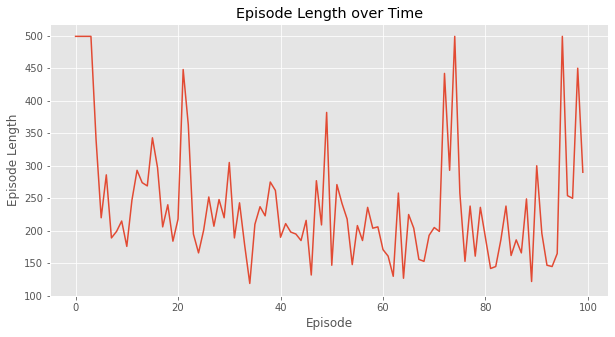

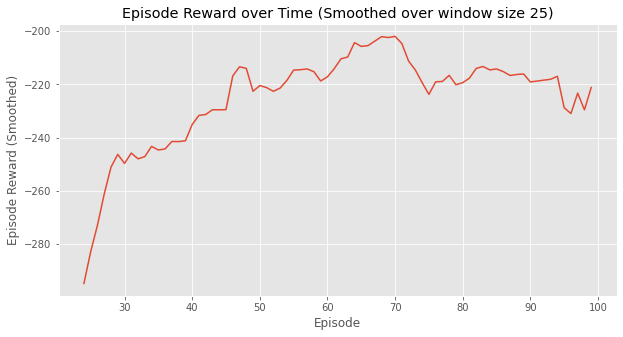

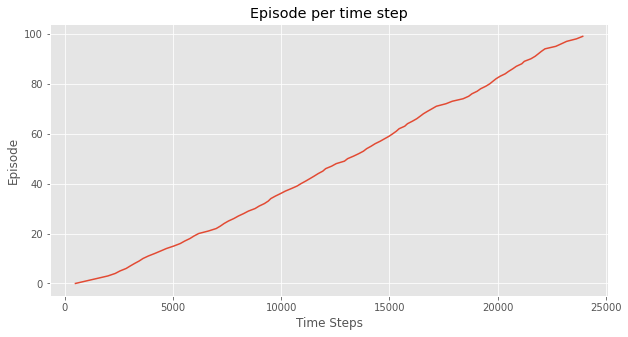

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [10]:
plotting.plot_episode_stats(stats, smoothing_window=25)

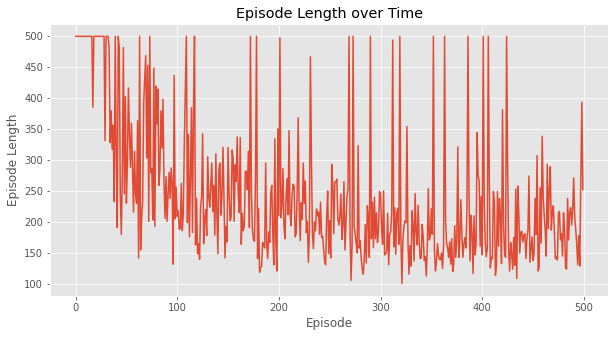

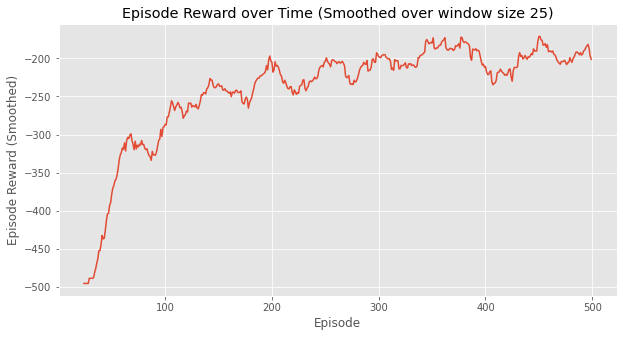

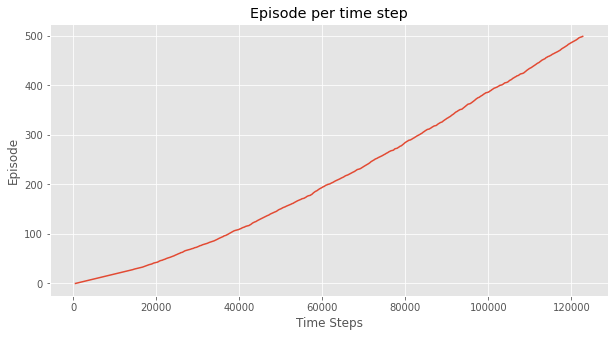

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [19]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [28]:
# state = env.observation_space.sample()
state = env.reset()
# plt.figure()
# plt.imshow(env.render(mode='rgb_array'))
while True:
    q_values = estimator.predict(state)
    best_action = np.argmax(q_values)
#     plt.figure()
#     plt.imshow(env.render(mode='rgb_array'))

#     action_pge = get_pge_action(best_action)
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render()
# env.close()

In [63]:
env.observation_space.sample()

array([-0.11945403,  0.29413375, -1.4568335 , -0.17493604,  0.40899193,
        0.73602676,  1.3300323 ,  0.1892223 ], dtype=float32)

In [31]:
env = gym.make('CartPole-v1')

In [61]:
env.reset()
env.step(env.action_space.sample())

(array([ 0.00353907,  0.19214232, -0.0343606 , -0.34522076]), 1.0, False, {})

In [123]:
env.step(env.action_space.sample())

(array([-0.74117499, -1.35688824,  0.28442935,  1.79704102]), 0.0, True, {})

In [29]:
env.close()